# GEOG696C Spatiotemporal Data Analysis
## Homework #4
Alex Saunders | Last updated: 14 October 2023

In [1]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, colors
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe
from datetime import datetime
import calendar
import scipy
import xarray
import cartopy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

In [2]:
# Set the root path
# rootPath = Path('C:/Users/alexa/Documents/GitHub/spatiotemporal_data_analysis/00_hw')
# rootPath = Path('C:/Users/alexsaunders/Documents/01_uoa/04_git/spatiotemporal_data_analysis/00_hw')
# rootPath = Path('C:/Users/alexsaunders/Documents/01_uoa/04_git/spatiotemporal_data_analysis/00_hw')
# dataPath = Path ('C:/Users/alexsaunders/Documents/01_uoa/01_study/2023/geog696c/data')
rootPath = Path('C:/Users/alexa/Documents/GitHub/spatiotemporal_data_analysis/00_hw')
dataPath = Path ('C:/Users/alexa/Documents/01_personal/07_phd/05_study/02_courses/2023/1/GEOG696/data')

## 3. Calculate and map the eigen modes of variability of winter Pacific SSTs
For the same domain as Deser and Blackon (1995)

### Initial processing of the SST data as prep for SVD

(153, 80, 140)
(153, 11200)
(153, 9329)


(array([1.200e+01, 9.600e+01, 4.340e+02, 1.437e+03, 3.691e+03, 2.469e+03,
        9.460e+02, 2.020e+02, 3.900e+01, 3.000e+00]),
 array([-5.17352737e-06, -4.09144968e-06, -3.00937245e-06, -1.92729476e-06,
        -8.45217357e-07,  2.36860160e-07,  1.31893762e-06,  2.40101508e-06,
         3.48309277e-06,  4.56517000e-06,  5.64724769e-06]),
 <BarContainer object of 10 artists>)

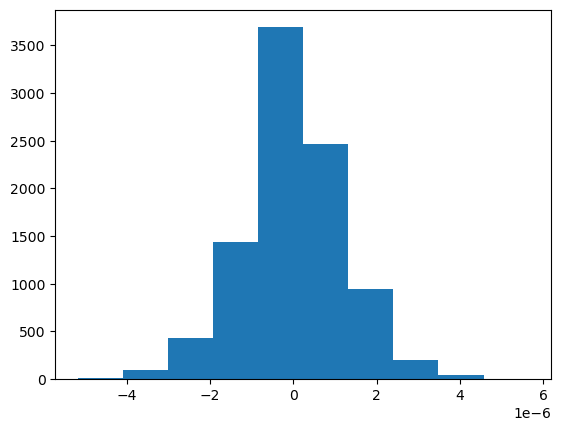

In [3]:
# Load the SST data, HadISST Rayner et al 2003
sstData = xarray.open_dataset(dataPath/'HadISST_sst.nc', engine='netcdf4') 
sst = sstData.sst

# Set missing values to na
sst = sst.where(sst>=0, np.nan)

# Transform the coord system from -180to180 longitude, to 0to360 degrees
sst = sst.assign_coords(longitude=(sst.longitude % 360))
# have to also sort the coordinates and associated data so they are in the correct order from 0 to 360
sst = sst.sortby(sst.longitude)

# Specify the desired area, and find corresponding start and end lat/lons that are present in the data
lons=[120, 260]
lats=[60, -20]
sst = sst.sel(longitude=slice(lons[0], lons[1]), latitude=slice(lats[0], lats[1]))

# Extract coordinates
lat = sst.latitude
lon = sst.longitude

# We use the rolling mean technique, with window of 5 months, taking only the ones ending in March
sstRolling = sst.rolling(time = 5).mean(skipna=True)

# Select March to get the average over NDJFM
endMo=3
sstSeasonal = sstRolling[sstRolling.time.dt.month==endMo]

# Drop the first which is an incomplete year
sstSeasonal = sstSeasonal.drop_isel(time=[0])

# Convert to np array for reshaping
ntime, nlat, nlon = sstSeasonal.shape
print(sstSeasonal.shape)
sstMat = np.array(sstSeasonal).reshape(ntime, nlat*nlon, order='F')
print(sstMat.shape)

# Drop locations wtih missing values
sstMatComplete = sstMat[:, ~np.isnan(sstMat).any(axis=0)]
print(sstMatComplete.shape)

# Get the mean and subtract it from the yearly seasonal average values, at ech location
sstAnom = sstMatComplete - sstMatComplete.mean(axis=0)


# Quick histogram to check the distribution of anomaly values centrs about zero
plt.hist(np.mean(sstAnom, axis=0))

### Peform the SVD and get the EOFs (spatial) and PCs (temporal)
Here we will perform SVD on the data anomalies themselves, rather than the covariance matrix.

In [4]:
# Retrieve the years, and the location lat lons (excluding the missing value locations)
years = range(sstSeasonal.time.dt.year.min().values, sstSeasonal.time.dt.year.max().values+1)
sstMatOrig=np.array(sstSeasonal).reshape(len(sstSeasonal.time), len(sstSeasonal.latitude)*len(sstSeasonal.longitude), order='F')
missingLocs = ~np.isnan(sstMatOrig).any(axis=0)
locLats=[]
locLons=[]
allLats=[]
allLons=[]
i=0
for lat in sstSeasonal.latitude.values:
    for lon in sstSeasonal.longitude.values:
        if missingLocs[i]==True:
            locLats.append(lat)
            locLons.append(lon)
        allLats.append(lat)
        allLons.append(lon)
        i=i+1        
latitudes = sst.latitude
longitudes = sst.longitude

In [5]:
# Perform SVD
U, s, Vt = np.linalg.svd(sstAnom, full_matrices=False)
print(U.shape, s.shape, Vt.shape)
V=Vt.T

# Create the eofs, with dimensions of the original lat lon grid
eofs = np.zeros([nlat*nlon, ntime]) * np.nan # 2D
eofs[missingLocs, :] = V
eofs = eofs.reshape([nlat, nlon, ntime], order='F')
print(eofs.shape)

# Calculate the pcs
pcs = sstAnom @ V
print(pcs.shape)

# Get the % of variance explained by the eigen modes from the real data
eigenVals=(s**2)/(len(s)-1)
expVar = (s / np.sum(s)) * 100

(153, 153) (153,) (153, 9329)
(80, 140, 153)
(153, 153)


### Map the EOFs

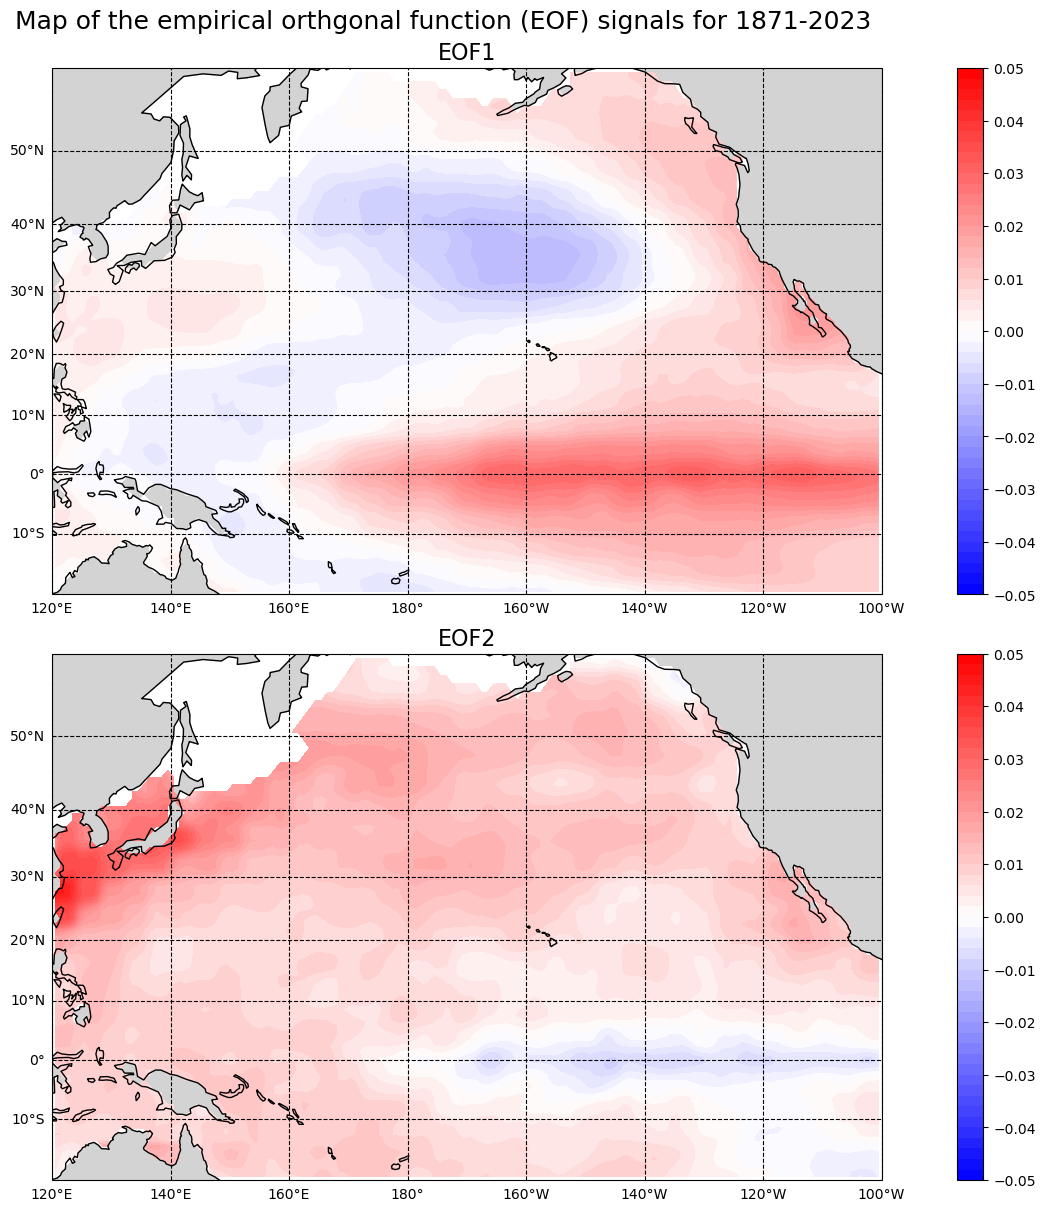

In [73]:
levels = np.linspace(-0.05, 0.05, 51)

fig, axes = plt.subplots(2, 1, figsize=(12,12), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=260)})

fig.suptitle('Map of the empirical orthgonal function (EOF) signals for {0}-{1}'.format(min(years), max(years)), fontsize=18)

# EOF1
ax=axes[0]
ax.set_title('EOF1', fontsize=16)
ax.coastlines(color="black") 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.set_extent([lons[0], lons[1], lats[1], lats[0]], crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=[-10, 0, 10, 20, 30, 40, 50, 60], xlocs=[120, 140, 160, 180, -160, -140, -120, -100])
eof1Plot = ax.contourf(longitudes, latitudes, eofs[:,:,0], cmap='bwr', levels=levels,vmin=-0.05, vmax=0.05, transform=ccrs.PlateCarree()) 
cb1 = plt.colorbar(eof1Plot, orientation='vertical', ticks=np.linspace(-0.05, 0.05, 11))

# EOF2
ax=axes[1]
ax.set_title('EOF2', fontsize=16)
ax.coastlines(color="black") 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.set_extent([lons[0], lons[1], lats[1], lats[0]], crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=[-10, 0, 10, 20, 30, 40, 50, 60], xlocs=[120, 140, 160, 180, -160, -140, -120, -100])
eof2Plot = ax.contourf(longitudes, latitudes, eofs[:,:,1], cmap='bwr', levels=levels,vmin=-0.05, vmax=0.05, transform=ccrs.PlateCarree()) 
cb1 = plt.colorbar(eof2Plot, orientation='vertical', ticks=np.linspace(-0.05, 0.05, 11))

ax.set_aspect('equal')

plt.show()

### Plot the PC time series

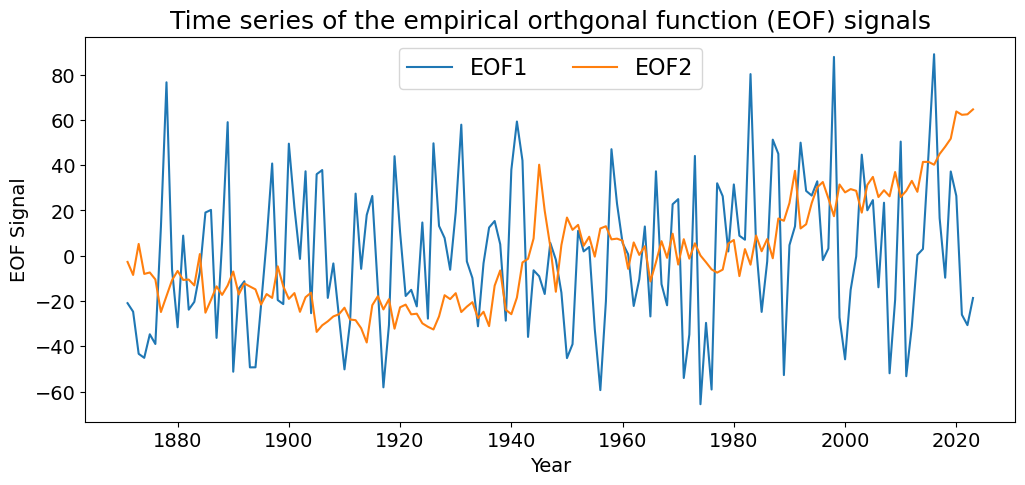

In [7]:
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title('Time series of the empirical orthgonal function (EOF) signals', fontsize=18)

ax.plot(years, pcs[:,0], label='EOF1')
ax.plot(years, pcs[:,1], label='EOF2')

ax.tick_params(which='both', labelsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('EOF Signal', fontsize=14)

ax.legend(fontsize=16, ncol=2)


plt.show()

## 4. Perform a Rule N significance test using Gaussian random noise conditioned on the data 

In [8]:
sstAnom

array([[-0.81125546, -0.73909235, -0.49568653, ..., -0.18889809,
        -0.17726326, -0.16753197],
       [-0.5472989 , -0.4939909 , -0.40617466, ..., -0.60005   ,
        -0.54001236, -0.50608253],
       [ 0.59580183,  0.56746006,  0.57190704, ..., -0.58600044,
        -0.54836273, -0.52563286],
       ...,
       [ 1.3255363 ,  1.2303286 ,  1.3259029 , ..., -0.7892113 ,
        -0.79382896, -0.793417  ],
       [ 1.2738614 ,  1.1800709 ,  1.4362755 , ..., -0.8950443 ,
        -0.9154587 , -0.9166012 ],
       [ 1.4123235 ,  1.3521166 ,  1.3804274 , ..., -0.22208214,
        -0.21880913, -0.21614838]], dtype=float32)

In [9]:
# Get mean and stdev of data values for conditioning the noise
mu = sstAnom.mean(axis=0)
sigma = sstAnom.std(axis=0)

In [10]:
# Create empty list for saving eignevalues results
eigenValsAll=[]
for i in range(0, 100):
    # Create random Gaussian matrix conditioned on the data (with mean and stdev), then subtract the mean
    randomMat = np.random.normal(mu, sigma, sstAnom.shape) # sstAnom
    randomMat = (randomMat - randomMat.mean(axis=0)) / randomMat.std(axis=0)
    
    # Get eigen vectors and eigen values
    U, s, Vt = np.linalg.svd(randomMat, full_matrices=False)
    V=Vt.T
    eigenVals=(s**2)/(len(s)-1)
    # Save the eigen values
    eigenValsAll.append(eigenVals)
    
    # # calculate the covariance and then use svd to get the eigenvalues and eigenvectors
    # covMat = np.cov(randomMat, rowvar=False, ddof=1) # get the covariance of the random matrix
    # U, s, Vt = scipy.sparse.linalg.svds(covMat, k=153)
    # # U, s, Vt = np.linalg.svd(covMat) # factor the covariance matrix into eigenvalues and eigenvectors
    # eigenValsAll.append(s)

In [11]:
# Get the 95%ile of the random data eigenvalues, for each mode
pct=0.95
modePcts=[]
for mode in range(eigenValsAll[0].shape[0]):
    eigenVals = [eigenVal[mode] for eigenVal in eigenValsAll]
    modePct = np.percentile(eigenVals, pct)
    modePcts.append(modePct)
    
# Convert the 95%ile eigenvalues for each mode into explained variance
expVarRandom = (modePcts / np.sum(modePcts)) * 100
expVarRandom.sort()
expVarRandom=np.flip(expVarRandom)

# Determine which modes from our analysis 'pass' this significance test
modesPassed = np.array(range(1, len(expVar)+1))[expVar>expVarRandom]
print(modesPassed)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30 153]


## 5. Perform a Rule N significance test using red autocorrelated noise

In [12]:
# Determine a mean phi value to use based on first order autocorrelation in the data
acf1 = pd.DataFrame(sstAnom).apply(lambda x: x.autocorr())

# Create empty list for saving simulated red noise eigenvalues
eigenValsAll=[]

# loop through the j iterations with an inner loop through the i rows of the simulated red noise matrix
for j in range(0, 100):
    
    # Create an empty matrix to accept the red noise simulation
    redMat = np.full(sstAnom.shape, np.nan) 
    
    # mean value and the variance of the random distribution
    c = sstAnom.mean(axis=0) # we have a zero-mean process
    sigma_e = np.sqrt((1 - acf1 ** 2))  # sets the appropriate standard deviation for [0,1] data

    # set the first value in the array as a random draw with the correct mean and variance
    redMat[0,:] = np.array([c + np.random.normal(0, sigma_e, size=sstAnom.shape[1])])

    # inner loop i that goes row-by-row to generate the red noise simulation
    for i in range(1, sstAnom.shape[0]):
        redMat[i,:] = np.array([c + (acf1 * redMat[i-1,:]) + np.random.normal(0, sigma_e, size=sstAnom.shape[1])])
    
    # Get eigen vectors and eigen values
    U, s, Vt = np.linalg.svd(redMat, full_matrices=False)
    V=Vt.T
    eigenVals=(s**2)/(len(s)-1)
    # Save the eigen values
    eigenValsAll.append(eigenVals)
    
    # # calculate the covariance and then use svd to get the eigenvalues and eigenvectors
    # covMat = np.cov(redMat, rowvar=False, ddof=1) # get the covariance of the random matrix
    # U, s, Vt = np.linalg.svd(covMat, k=153) # factor the covariance matrix into eigenvalues and eigenvectors
    # eigenValsAll.append(s)

In [13]:
# Get the 95%ile of the random data eigenvalues, for each mode
pct=0.95
modePcts=[]
for mode in range(eigenValsAll[0].shape[0]):
    eigenVals = [eigenVal[mode] for eigenVal in eigenValsAll]
    modePct = np.percentile(eigenVals, pct)
    modePcts.append(modePct)
    
# Convert the 95%ile eigenvalues for each mode into explained variance
expVarRed = (modePcts / np.sum(modePcts)) * 100
expVarRed.sort()
expVarRed=np.flip(expVarRed)

# Determine which modes from our analysis 'pass' this significance test
modesPassed = np.array(range(1, len(expVar)+1))[expVar>expVarRed]
print(modesPassed)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


### Plot the Rule N test with a scree plot

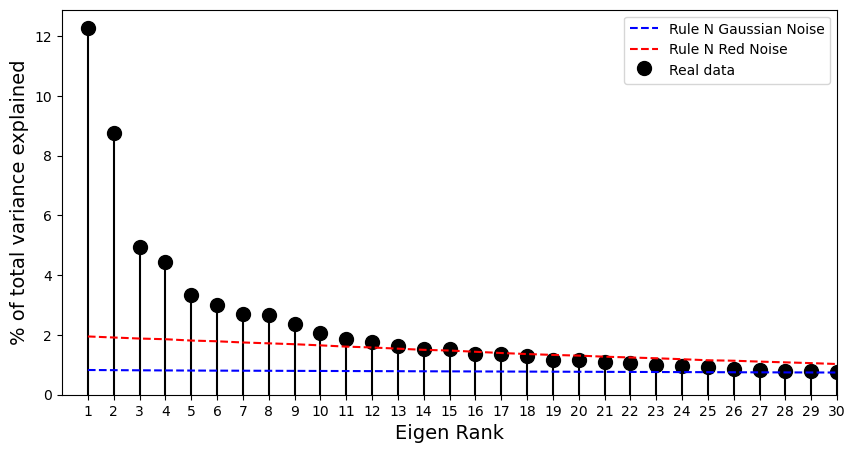

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

markerline, stemlines, baseline = ax.stem(range(1, len(expVar) + 1), expVar, label='Real data')#, use_line_collection=True)

plt.setp(stemlines, color='k')
plt.setp(markerline, marker='o', markersize=10, color='k', zorder=2)
plt.setp(baseline, color='none', zorder=1)

ax.plot(range(1, len(expVarRandom)+1), expVarRandom, color='blue', linestyle='--', label='Rule N Gaussian Noise')
ax.plot(range(1, len(expVarRed)+1), expVarRed, color='red', linestyle='--', label='Rule N Red Noise')


ax.set_xlabel('Eigen Rank', fontsize=14)
ax.set_ylabel('% of total variance explained', fontsize=14)
ax.set_xticks(range(1, len(expVar) + 1))
ax.set_xlim(0, 30)
ax.set_ylim(bottom=0)

ax.legend()

plt.show()

__How many modes of North Pacific winter SSTs are "significant, meaningful, interpretable and/or differentiated from noise?"__

I am not totally convinces I have the correct result for the Gaussian noise Rule N test, but based on the Red Noise RUle N test, which in this instance is probably more satisfactory anyway, I would deem the first 15 modes to be significant and meaningful.

## 6. Perform a 'field correlation' analysis
The correlation between a single time series and the time series at every point in the field

In [15]:
# Get data and PCs in xarray for easy correlation
pcsXr = xarray.DataArray(pcs,
                        dims=("time","mode"),
                        coords=[
                            ("time", sstSeasonal.time.values),
                            ("mode", range(1,len(years)+1)),
                        ],)

# sstAnomXr = xarray.DataArray(sstAnom,
#                         dims=("year","loc"),
#                         coords=[
#                             ("year", years),
#                             ("loc", range(1,sstAnom.shape[1]+1)),
#                         ],)

# For EOF 1 and EOF 2 time series, compute correlation with the original SST data
fieldCorr = xarray.corr(sstSeasonal, pcsXr, dim="time")

C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexa\anaconda3\envs\spatiotemp3\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Plot maps of field correlation for the first two modes

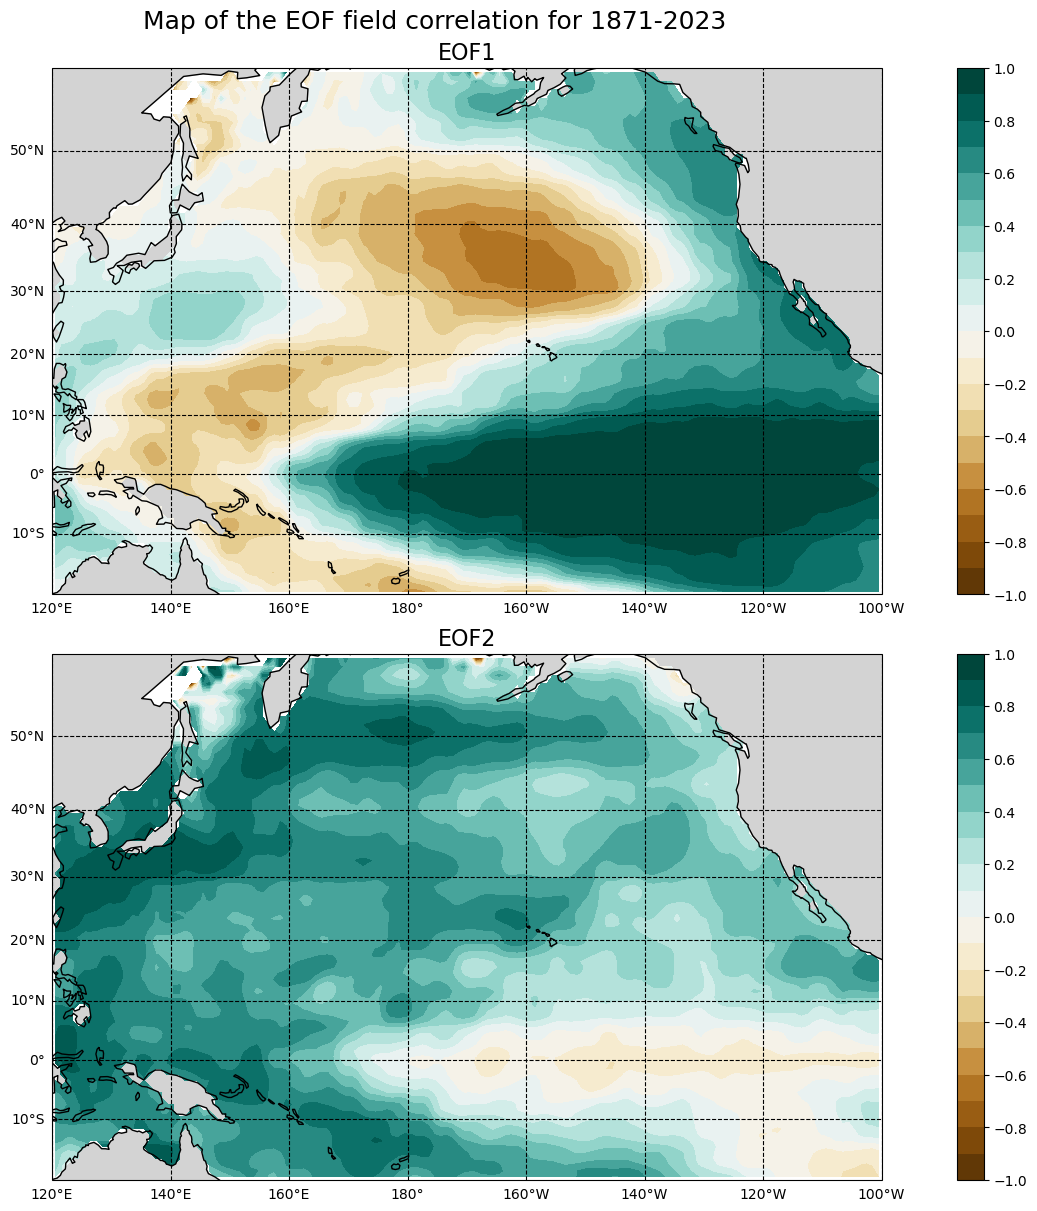

In [16]:
levels = np.linspace(-1, 1, 21)

fig, axes = plt.subplots(2, 1, figsize=(12,12), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=260)})

fig.suptitle('Map of the EOF field correlation for {0}-{1}'.format(min(years), max(years)), fontsize=18)

# EOF1
ax=axes[0]
ax.set_title('EOF1', fontsize=16)
ax.coastlines(color="black") 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.set_extent([lons[0], lons[1], lats[1], lats[0]], crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=[-10, 0, 10, 20, 30, 40, 50, 60], xlocs=[120, 140, 160, 180, -160, -140, -120, -100])
eof1Plot = ax.contourf(longitudes, latitudes, fieldCorr.sel(mode=1).values, cmap='BrBG', levels=levels, vmin=-1, vmax=1, transform=ccrs.PlateCarree()) 
cb1 = plt.colorbar(eof1Plot, orientation='vertical', ticks=np.linspace(-1, 1, 11))

# EOF2
ax=axes[1]
ax.set_title('EOF2', fontsize=16)
ax.coastlines(color="black") 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.set_extent([lons[0], lons[1], lats[1], lats[0]], crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=[-10, 0, 10, 20, 30, 40, 50, 60], xlocs=[120, 140, 160, 180, -160, -140, -120, -100])
eof2Plot = ax.contourf(longitudes, latitudes, fieldCorr.sel(mode=2).values, cmap='BrBG', levels=levels, vmin=-1, vmax=1, transform=ccrs.PlateCarree()) 
cb1 = plt.colorbar(eof2Plot, orientation='vertical', ticks=np.linspace(-1, 1, 11))

ax.set_aspect('equal')

plt.show()

__How do the maps compare with the results from Deser and Blackmon (1995)?__

These maps of correlation of EOFs 1 and 2 with the original data are very similar in appearance to the maps from Deser and Blackmon (1995). In EOF1, the overall pattern and the magnitudes of the values are in close agreement with their paper. In EOF2, the signs of my correlations are switched around, whcih suggests I did not flip the EOF sign. Otherwise, the pattern is somewhat similar, although matches less well than EOF1. This is similar to what we saw in HW2, since the data we have is more recent than Deser and Blackmon (1995), we might capture some additional behaviors that have occurred in the most recent 25 years.

## 7 Identify the years with the highest and lowest of the signal values, for EOF 1

In [17]:
upper=pcsXr.sel(mode=1).quantile(0.90)
lower=pcsXr.sel(mode=1).quantile(0.10)

upperYears= [pd.Timestamp(item).year for item in pcsXr.sel(mode=1).time[pcsXr.sel(mode=1) >= upper].values]
lowerYears= [pd.Timestamp(item).year for item in pcsXr.sel(mode=1).time[pcsXr.sel(mode=1) <= lower].values]

print('Upper 10%ile: ', upperYears)
print('Lower 10%ile: ', lowerYears)

Upper 10%ile:  [1878, 1889, 1900, 1926, 1931, 1941, 1958, 1983, 1987, 1988, 1992, 1998, 2003, 2010, 2015, 2016]
Lower 10%ile:  [1873, 1874, 1890, 1893, 1894, 1910, 1917, 1950, 1956, 1971, 1974, 1976, 1989, 2000, 2008, 2011]


## 8. Import the reanalysis 500mb height data and slice for the same time period as the SST

In [18]:
(dataPath/'hgt_500mb_mon_mean.nc').exists()

True

In [19]:
# Load the SST data, HadISST Rayner et al 2003
hgtData = xarray.open_dataset(dataPath/'hgt_500mb_mon_mean.nc') 

In [20]:
hgt = hgtData.hgt

In [21]:
hgt

<xarray.DataArray 'hgt' (time: 2160, level: 1, lat: 181, lon: 360)>
[140745600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * level    (level) float32 500.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1836-01-01 1836-02-01 ... 2015-12-01
Attributes: (12/15)
    long_name:         Monthly Geopotential Height on Pressure Levels
    cell_methods:      time: mean (monthly from 3-hourly values)
    units:             m
    GRIB_name:         HGT
    var_desc:          Geopotential height
    dataset:           NOAA/CIRES/DOE 20th Century Reanalysis version 3si-mo ...
    ...                ...
    standard_name:     geopotential_height
    valid_range:       [-1500. 60000.]
    statistic_method:  Ensemble mean is calculated by averaging over all 80 e...
    GridType:          Cylindrical Equidistant Projection Grid
    datum:             wgs84
    actual_range:      [ -307.88  50208.145]

In [22]:
# restrict to the same time period
hgt = hgt.sel(time=slice(sst.time.min(), sst.time.max()))

## 9. Create a Nov-March average for each year and remove the long-term mean for each location

In [23]:
# We use the rolling mean technique, with window of 5 months, taking only the ones ending in March
hgtRolling = hgt.rolling(time = 5).mean(skipna=True)

# Select March to get the average over NDJFM
endMo=3
hgtSeasonal = hgtRolling[hgtRolling.time.dt.month==endMo]

# Drop the first which is an incomplete year
hgtSeasonal= hgtSeasonal.drop_isel(time=[0])

In [24]:
# Subtract the mean
hgtAnom = hgtSeasonal - hgtSeasonal.mean(axis=0)

## 10. Using the years from the earlier step, prepare and map a composite average for the pressure height anomaly field, for each set of years

In [25]:
upperPCs = pcsXr.sel(mode=1).time[pcsXr.sel(mode=1) >= upper]
lowerPCs = pcsXr.sel(mode=1).time[pcsXr.sel(mode=1) <= lower]

In [30]:
hgtYears = [int(str(item).split('-')[0]) for item in hgtAnom.time.values]
upperIdx = [i for i, item in enumerate(hgtYears) if item in upperYears]
lowerIdx = [i for i, item in enumerate(hgtYears) if item in lowerYears]

In [31]:
# Get an average of the height data for the upper SST years
hgtCompUpper = hgtAnom.isel(time=upperIdx).mean(axis=0)
hgtCompLower = hgtAnom.isel(time=lowerIdx).mean(axis=0)

### Plot the composite maps

(array([  204.,   237.,   287.,   362.,  1249.,  6766., 22320., 30326.,
         2928.,   481.]),
 array([-72.78043365, -61.36631393, -49.9521904 , -38.53807068,
        -27.12395096, -15.70982933,  -4.29570866,   7.11841249,
         18.53253365,  29.94665337,  41.36077499]),
 <BarContainer object of 10 artists>)

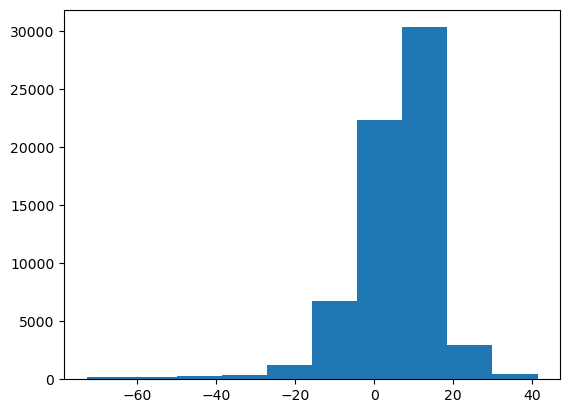

In [56]:
plt.hist(hgtCompUpper.sel(level=500).values.flatten())

(array([  499.,  1035.,  8690., 26788., 14198.,  7774.,  3938.,  1395.,
          511.,   332.]),
 array([-33.24832153, -25.82865906, -18.40899658, -10.98933411,
         -3.56967163,   3.84999084,  11.26965332,  18.6893158 ,
         26.10897827,  33.52864075,  40.94830322]),
 <BarContainer object of 10 artists>)

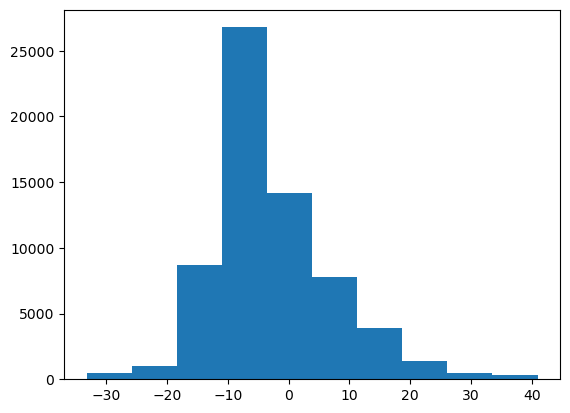

In [68]:
plt.hist(hgtCompLower.sel(level=500).values.flatten())

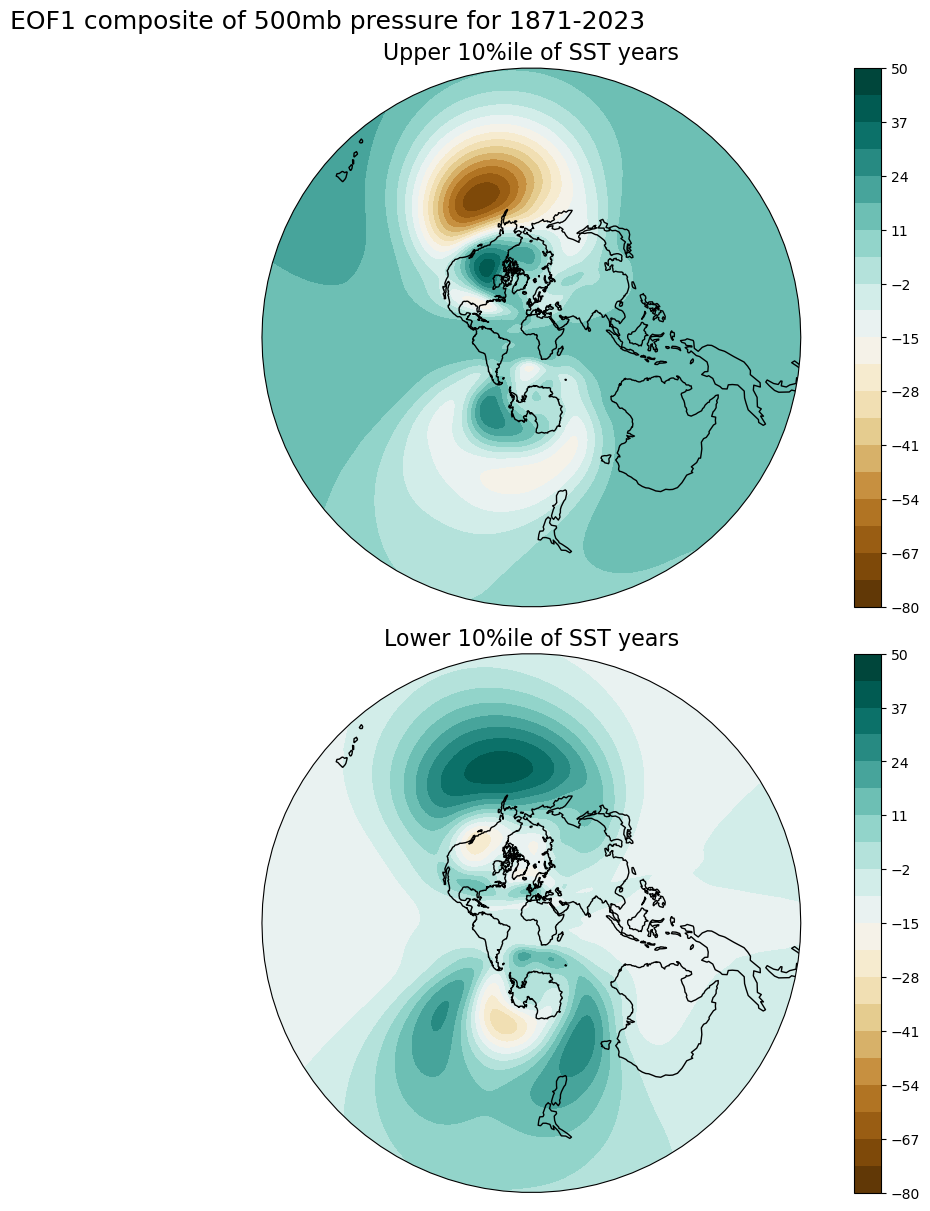

In [72]:
levels = np.linspace(-80, 50, 21)

fig, axes = plt.subplots(2, 1, figsize=(12,12), constrained_layout=True, subplot_kw={'projection': ccrs.Stereographic()})

fig.suptitle('EOF1 composite of 500mb pressure for {0}-{1}'.format(min(years), max(years)), fontsize=18)

# Composite of upper SST years
ax=axes[0]
ax.set_title('Upper 10%ile of SST years', fontsize=16)
ax.coastlines(color="black") 
ax.add_feature(cfeature.LAND, color='lightgray')
eof1Plot = ax.contourf(hgtCompUpper.lon, hgtCompUpper.lat, hgtCompUpper.sel(level=500).values, cmap='BrBG', transform=ccrs.PlateCarree(), levels=levels, vmin=-80, vmax=50) 
cb1 = plt.colorbar(eof1Plot, orientation='vertical', ticks=np.linspace(-80, 50, 11))

# Composite of upper SST years
ax=axes[1]
ax.set_title('Lower 10%ile of SST years', fontsize=16)
ax.coastlines(color="black") 
ax.add_feature(cfeature.LAND, color='lightgray')
eof1Plot = ax.contourf(hgtCompLower.lon, hgtCompLower.lat, hgtCompLower.sel(level=500).values, cmap='BrBG', transform=ccrs.PlateCarree(), levels=levels, vmin=-80, vmax=50) 
cb1 = plt.colorbar(eof1Plot, orientation='vertical', ticks=np.linspace(-80, 50, 11))

ax.set_aspect('equal')

plt.show()

__How do these "positive" EOF1 values (i.e. upper 10%ile) compare to "negative" EOF1 values (i.e. lower 10%ile)?__

The positive values represent El Nino years. The negative values represent La Nina years. During the El Nino years, the highest positive pressues were centered over the North American continent, and the Southern Ocean. During La Nina years, the pattern of the pressures is to the first order, a flipped version of the El Nino years, with highest pressures in the Arctic Ocean and Southern Indian Ocean.